In [152]:
import pandas as pd

In [153]:
movies_metadata = pd.read_csv('movies_title_tag_basic_info.csv')
ratings = pd.read_csv(r'ratings_small_filtered_2.csv', index_col=0)

In [154]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 81730 entries, 0 to 81729
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   userId     81730 non-null  int64  
 1   movieId    81730 non-null  int64  
 2   rating     81730 non-null  float64
 3   timestamp  81730 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [155]:
unique_movieId_list = list(ratings['movieId'].unique())
len(unique_movieId_list)

6347

In [156]:
movies_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44475 entries, 0 to 44474
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  44475 non-null  int64 
 1   tmdbId   44475 non-null  int64 
 2   title    44475 non-null  object
 3   tags     44475 non-null  object
dtypes: int64(2), object(2)
memory usage: 1.4+ MB


In [157]:
movies_metadata = movies_metadata[movies_metadata['movieId'].isin(unique_movieId_list)]
movies_metadata.reset_index(drop=True, inplace=True)
movies_metadata.drop(['tmdbId','title'], axis=1, inplace=True)


In [158]:
movies_metadata

,movieId,tags
0,1,"Led by Woody, Andy's toys live happily in his ..."
1,2,When siblings Judy and Peter discover an encha...
2,3,A family wedding reignites the ancient feud be...
3,4,"Cheated on, mistreated and stepped on, the wom..."
4,6,"Obsessive master thief, Neil McCauley leads a ..."
...,...,...
6317,130682,After narrowly escaping an ancient burial grou...
6318,130970,Carlin returns to the stage in his 13th live c...
6319,130980,Stunning espionage documentary on the US consp...
6320,131013,When obscenely rich hedge-fund manager James i...


In [159]:
movies_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6322 entries, 0 to 6321
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  6322 non-null   int64 
 1   tags     6322 non-null   object
dtypes: int64(1), object(1)
memory usage: 98.9+ KB


In [160]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

tfidf = TfidfVectorizer(stop_words='english')

tfidf_matrix = tfidf.fit_transform(movies_metadata['tags'])

cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
indices = pd.Series(movies_metadata.index, index=movies_metadata['movieId']).drop_duplicates()
def get_recommendations(title, cosine_sim=cosine_sim):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    movie_indices = [i[0] for i in sim_scores]
    return movies_metadata['movieId'].iloc[movie_indices]

In [161]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 81730 entries, 0 to 81729
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   userId     81730 non-null  int64  
 1   movieId    81730 non-null  int64  
 2   rating     81730 non-null  float64
 3   timestamp  81730 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [162]:
ratings['rating'] = ratings['rating'].apply(lambda x: 1 if x > 3.5 else 0)

In [163]:
ratings

,userId,movieId,rating,timestamp
0,1,31,0,1260759144
1,1,1061,0,1260759182
2,1,1129,0,1260759185
3,1,1172,1,1260759205
4,1,1263,0,1260759151
...,...,...,...,...
81725,671,6212,0,1065149436
81726,671,6268,0,1065579370
81727,671,6365,1,1070940363
81728,671,6385,0,1070979663


In [164]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 81730 entries, 0 to 81729
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   userId     81730 non-null  int64
 1   movieId    81730 non-null  int64
 2   rating     81730 non-null  int64
 3   timestamp  81730 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB


In [165]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix



# Step 1: Create the TF-IDF matrix and compute cosine similarity
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies_metadata['tags'])
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Create a reverse mapping of indices and movieId
indices = pd.Series(movies_metadata.index, index=movies_metadata['movieId']).drop_duplicates()

def get_recommendations(movieId, cosine_sim=cosine_sim):
    if movieId not in indices:
        return []
    idx = indices[movieId]
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]  # Top 10 similar movies
    movie_indices = [i[0] for i in sim_scores]
    return movies_metadata['movieId'].iloc[movie_indices]

# Step 2: Integrate User Ratings
user_item_matrix = ratings.pivot(index='userId', columns='movieId', values='rating')

# Function to get k-nearest neighbors based on item-item similarity
def get_k_nearest_neighbors(item_similarity_df, movie_id, k=10):
    if movie_id not in item_similarity_df.columns:
        return pd.Index([])
    sim_scores = item_similarity_df[movie_id]
    nearest_neighbors = sim_scores.sort_values(ascending=False).index[1:k+1]
    return nearest_neighbors

# Function to predict rating for a specific user and movie
def predict_rating(user_item_matrix, item_similarity_df, user_id, movie_id, k=10):
    nearest_neighbors = get_k_nearest_neighbors(item_similarity_df, movie_id, k)
    if nearest_neighbors.empty:
        return 0
    neighbor_ratings = user_item_matrix.loc[user_id, nearest_neighbors]
    if neighbor_ratings.isna().all():
        return 0
    return Counter(neighbor_ratings.dropna()).most_common(1)[0][0]

# Compute the item similarity DataFrame using movie metadata
item_similarity_df = pd.DataFrame(cosine_sim, index=movies_metadata['movieId'], columns=movies_metadata['movieId'])

# Split the ratings data into training and testing sets
train_ratings = ratings.sample(frac=0.8, random_state=42)
test_ratings = ratings.drop(train_ratings.index)

# Evaluate at K=255
K = 255
y_true_all = []
y_pred_all = []

for index, row in test_ratings.iterrows():
    user_id = row['userId']
    movie_id = row['movieId']
    y_true_all.append(row['rating'])
    y_pred_all.append(predict_rating(user_item_matrix, item_similarity_df, user_id, movie_id, k=K))

# Convert to integers
y_true_all = [int(val) for val in y_true_all]
y_pred_all = [int(val) for val in y_pred_all]

# Generate classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_true_all, y_pred_all))

print("Confusion Matrix:")
print(confusion_matrix(y_true_all, y_pred_all))


Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.66      0.65      7901
           1       0.67      0.66      0.67      8445

    accuracy                           0.66     16346
   macro avg       0.66      0.66      0.66     16346
weighted avg       0.66      0.66      0.66     16346

Confusion Matrix:
[[5177 2724]
 [2871 5574]]


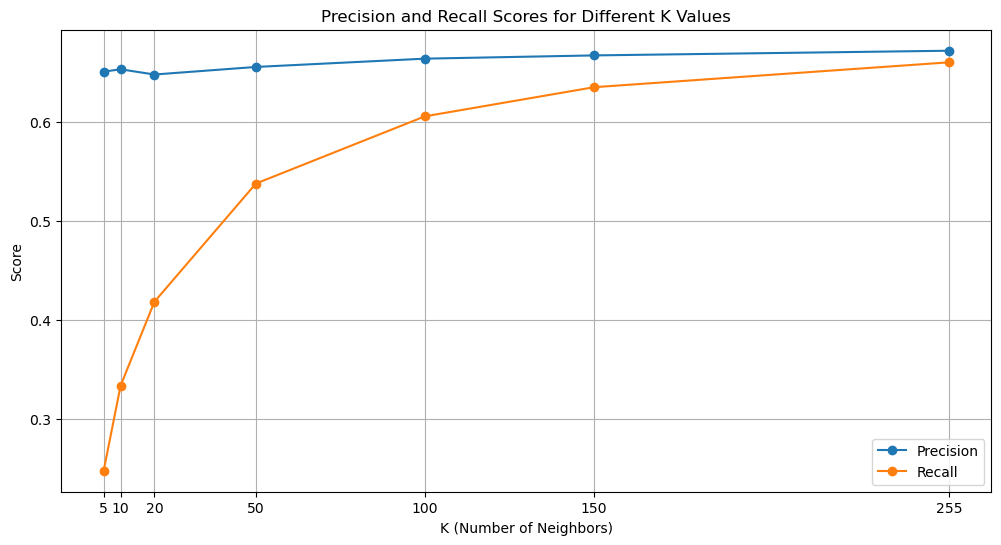

In [166]:
import matplotlib.pyplot as plt

# Define the list of K values
K_values = [5, 10, 20, 50, 100, 150, 255]

# Initialize lists to store precision and recall values for each K
precision_scores = []
recall_scores = []

for K in K_values:
    # Perform prediction and evaluation
    y_true_all = []
    y_pred_all = []

    for index, row in test_ratings.iterrows():
        user_id = row['userId']
        movie_id = row['movieId']
        y_true_all.append(row['rating'])
        y_pred_all.append(predict_rating(user_item_matrix, item_similarity_df, user_id, movie_id, k=K))

    # Convert to integers
    y_true_all = [int(val) for val in y_true_all]
    y_pred_all = [int(val) for val in y_pred_all]

    # Calculate precision and recall
    precision = precision_score(y_true_all, y_pred_all)
    recall = recall_score(y_true_all, y_pred_all)

    # Append scores to lists
    precision_scores.append(precision)
    recall_scores.append(recall)

# Plot the precision and recall scores for different values of K
plt.figure(figsize=(12, 6))
plt.plot(K_values, precision_scores, label='Precision', marker='o')
plt.plot(K_values, recall_scores, label='Recall', marker='o')
plt.xlabel('K (Number of Neighbors)')
plt.ylabel('Score')
plt.title('Precision and Recall Scores for Different K Values')
plt.xticks(K_values)
plt.legend()
plt.grid(True)
plt.show()
